# Activity: Build a K-means model 

## **Introduction**

K-means clustering is very effective when segmenting data and attempting to find patterns. Because clustering is used in a broad array of industries, becoming proficient in this process will help you expand your skillset in a widely applicable way.   

In this activity, you are a consultant for a scientific organization that works to support and sustain penguin colonies. You are tasked with helping other staff members learn more about penguins in order to achieve this mission. 

The data for this activity is in a spreadsheet that includes datapoints across a sample size of 345 penguins, such as species, island, and sex. Your will use a K-means clustering model to group this data and identify patterns that provide important insights about penguins.

**Note:** Because this lab uses a real dataset, this notebook will first require basic EDA, data cleaning, and other manipulations to prepare the data for modeling. 

## **Step 1: Imports** 


Import statements including `K-means`, `silhouette_score`, and `StandardScaler`.

In [22]:
 # Import standard operational packages.
import numpy as np
import pandas as pd
# Important tools for modeling and evaluation.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
# Import visualization packages.
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

`Pandas` is used to load the penguins dataset, which is built into the `seaborn` library. The resulting `pandas` DataFrame is saved in a variable named `penguins`. As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [4]:
penguins = sns.load_dataset("penguins")

Now, review the first 10 rows of data.


In [5]:
# Review the first 10 rows.

penguins.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,Female
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,Male
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


## **Step 2: Data exploration** 

After loading the dataset, the next step is to prepare the data to be suitable for clustering. This includes: 

*   Exploring data
*   Checking for missing values
*   Encoding data 
*   Dropping a column
*   Scaling the features using `StandardScaler`

### Explore data

To cluster penguins of multiple different species, determine how many different types of penguin species are in the dataset.

In [6]:
# Find out how many penguin types there are.
penguins["species"].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [7]:
# Find the count of each species type.
penguins["species"].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

### Check for missing values

An assumption of K-means is that there are no missing values. Check for missing values in the rows of the data. 

In [8]:
# Check for missing values.
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Now, drop the rows with missing values and save the resulting pandas DataFrame in a variable named `penguins_subset`.

In [9]:
# Drop rows with missing values.
# Save DataFrame in variable `penguins_subset`.
penguins_subset = penguins.dropna(axis=0).reset_index(drop=True)

Next, check to make sure that `penguins_subset` does not contain any missing values.

In [10]:
# Check for missing values.
penguins_subset.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

### Encode data

Some versions of the penguins dataset have values encoded in the sex column as 'Male' and 'Female' instead of 'MALE' and 'FEMALE'. The code below will make sure all values are ALL CAPS. 


In [11]:
penguins_subset["sex"] = penguins_subset["sex"].str.upper()

K-means needs numeric columns for clustering. Convert the categorical column `'sex'` into numeric. There is no need to convert the `'species'` column because it isn't being used as a feature in the clustering algorithm. 

In [13]:
# Convert `sex` column from categorical to numeric.
penguins_subset = pd.get_dummies(penguins_subset,drop_first=True,columns=["sex"])

### Drop a column

Drop the categorical column `island` from the dataset. While it has value, this notebook is trying to confirm if penguins of the same species exhibit different physical characteristics based on sex. This doesn't include location.

Note that the `'species'` column is not numeric. Don't drop the `'species'` column for now. It could potentially be used to help understand the clusters later. 

In [14]:
# Drop the island column.
penguins_subset = penguins_subset.drop(["island"], axis=1)

### Scale the features

Because K-means uses distance between observations as its measure of similarity, it's important to scale the data before modeling. Use a third-party tool, such as scikit-learn's `StandardScaler` function. `StandardScaler` scales each point xᵢ by subtracting the mean observed value for that feature and dividing by the standard deviation:

x-scaled = (xᵢ – mean(X)) / σ

This ensures that all variables have a mean of 0 and variance/standard deviation of 1. 

**Note:** Because the species column isn't a feature, it doesn't need to be scaled. 

First, copy all the features except the `'species'` column to a DataFrame `X`. 

In [15]:
# Exclude `species` variable from X
X = penguins_subset.drop(["species"],axis=1)

Scale the features in `X` using `StandardScaler`, and assign the scaled data to a new variable `X_scaled`. 

In [16]:
#Scale the features.
#Assign the scaled data to variable `X_scaled`.
X_scaled = StandardScaler().fit_transform(X)

## **Step 3: Data modeling** 

Now, fit K-means and evaluate inertia for different values of k. Because you may not know how many clusters exist in the data, start by fitting K-means and examining the inertia values for different values of k. To do this, write a function called `kmeans_inertia` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's inertia.

When using K-means inside the function, set the `random_state` to `42`. This way, others can reproduce your results.

In [17]:
# Fit K-means and evaluate inertia for different values of k.
num_clusters = [i for i in range(2,11)]

def kmeans_inertia(num_clusters,x_vals):
    """
    Accepts as arguments list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        k_means = KMeans(n_clusters=num,random_state=42)
        k_means.fit(x_vals)
        inertia.append(k_means.inertia_)

    return inertia

Use the `kmeans_inertia` function to return a list of inertia for k=2 to 10.

In [18]:
# Return a list of inertia for k=2 to 10.
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

c:\Users\emirh\anaconda3\envs\wazenv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\emirh\anaconda3\envs\wazenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\emirh\anaconda3\envs\wazenv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\emirh\anaconda3\envs\wazenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

[885.6224143652248,
 578.8284278107234,
 386.14534424773285,
 284.5464837898288,
 217.92858573807675,
 201.39287843423264,
 185.46131043232296,
 173.45452114979847,
 164.12001520260705]

Next, create a line plot that shows the relationship between `num_clusters` and `inertia`.
Use either seaborn or matplotlib to visualize this relationship. 

Text(0, 0.5, 'Inertia')

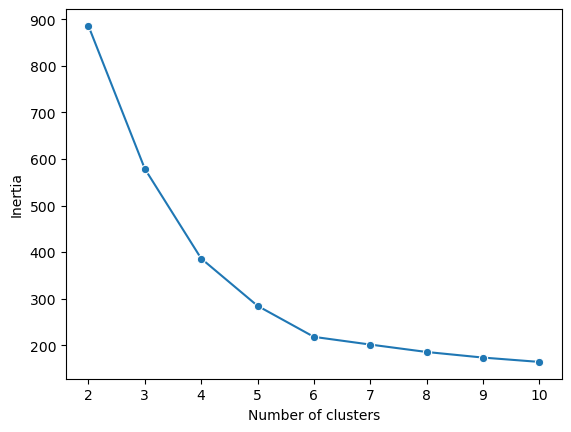

In [20]:
# Create a line plot.
plt = sns.lineplot(x = num_clusters, y = inertia, marker = "o")
plt.set_xlabel("Number of clusters")
plt.set_ylabel("Inertia");

**Question:** Where is the elbow in the plot?

The plot seems to depict an elbow at six clusters, but there isn’t a clear method for confirming that a six-cluster model is optimal. Therefore, the silhouette scores should be checked.

## **Step 4: Results and evaluation** 

Now, evaluate the silhouette score using the `silhouette_score()` function. Silhouette scores are used to study the distance between clusters. 

Then, compare the silhouette score of each value of k, from 2 through 10. To do this, write a function called `kmeans_sil` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's silhouette score.

In [23]:
# Evaluate silhouette score.
# Write a function to return a list of each k-value's score.

def kmeans_sil(num_clusters,x_vals):
    """
    Accepts as arguments list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value.
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        k_means = KMeans(n_clusters=num,random_state=42)
        k_means.fit(x_vals)
        sil_score.append(silhouette_score(x_vals,k_means.labels_))

    return sil_score

In [24]:
sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score


[0.44398088353055243,
 0.45101024097188364,
 0.5080140996630784,
 0.519998574860868,
 0.5263224884981607,
 0.47774022332151733,
 0.4221920732643224,
 0.36062890821417276,
 0.3617250563420018]

Next, create a line plot that shows the relationship between `num_clusters` and `sil_score`.
Use either seaborn or matplotlib to visualize this relationship. 

Text(0, 0.5, 'Silhouette Score')

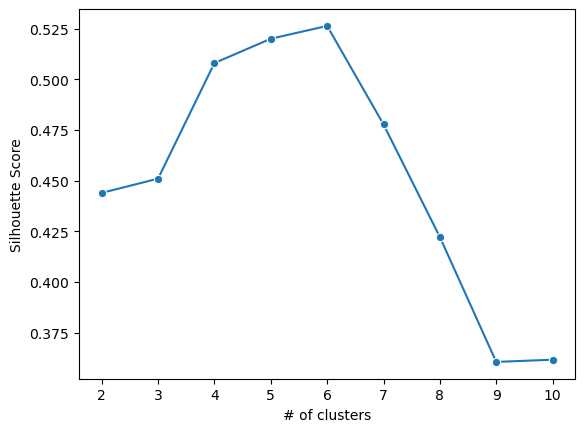

In [25]:
# Create a line plot.
plot = sns.lineplot(x=num_clusters, y=sil_score, marker = "o")
plot.set_xlabel("# of clusters")
plot.set_ylabel("Silhouette Score")

**Question:** What does the graph show?

Silhouette scores near 1 indicate that samples are far away from neighboring clusters. Scores close to 0 indicate that samples are on or very close to the decision boundary between two neighboring clusters.

The plot indicates that the silhouette score is closest to 1 when the data is partitioned into six clusters, although five clusters also yield a relatively good silhouette score.

### Optimal k-value

To decide on an optimal k-value, fit a six-cluster model to the dataset. 

In [26]:
# Fit a 6-cluster model.
kmeans6 = KMeans(n_clusters=6, random_state=42)
kmeans6.fit(X_scaled)

KMeans(n_clusters=6, random_state=42)

In [27]:
# Print unique labels.
print("Unique labels:", np.unique(kmeans6.labels_))

Unique labels: [0 1 2 3 4 5]


Now, create a new column `cluster` that indicates cluster assignment in the DataFrame `penguins_subset`. It's important to understand the meaning of each cluster's labels, then decide whether the clustering makes sense. 

**Note:** This task is done using `penguins_subset` because it is often easier to interpret unscaled data.

In [28]:
# Create a new column `cluster`.
penguins_subset["cluster"] = kmeans6.labels_
penguins_subset.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,cluster
0,Adelie,39.1,18.7,181.0,3750.0,True,2
1,Adelie,39.5,17.4,186.0,3800.0,False,1
2,Adelie,40.3,18.0,195.0,3250.0,False,1
3,Adelie,36.7,19.3,193.0,3450.0,False,1
4,Adelie,39.3,20.6,190.0,3650.0,True,2


Next, interpret the groupby outputs. Although the results of the groupby show that each `'cluster'` can be differentiated by `'species'`, it is useful to visualize these results. The graph shows that each `'cluster'` can be differentiated by `'species'`. 

**Note:** The code for the graph below is outside the scope of this lab. 

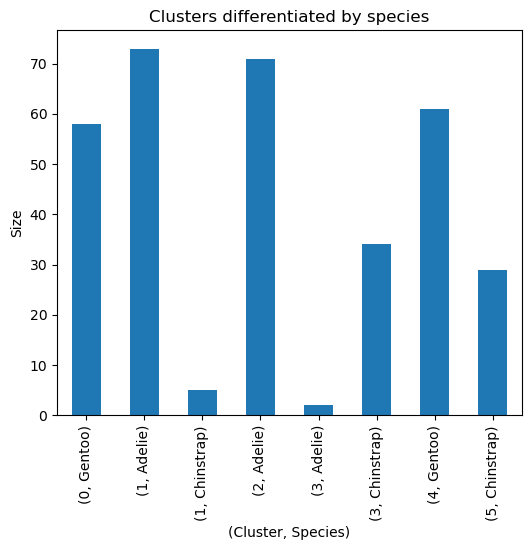

In [32]:
penguins_subset.groupby(by=["cluster", "species"]).size().plot.bar(title="Clusters differentiated by species",
                                                                   figsize=(6, 5),
                                                                   ylabel="Size",
                                                                   xlabel="(Cluster, Species)");

Finally, interpret the groupby outputs and visualize these results. The graph shows that each `'cluster'` can be differentiated by `'species'` and `'sex_MALE'`. Furthermore, each cluster is mostly comprised of one sex and one species. 

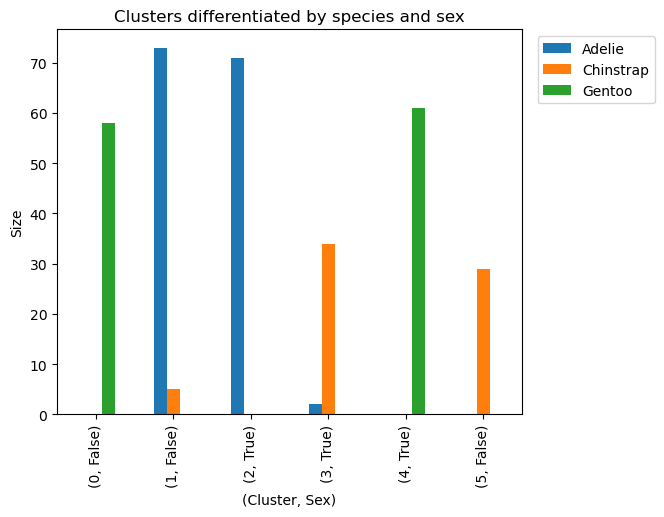

In [33]:
# Verify if each `cluster` can be differentiated by `species' AND `sex_MALE`.
(penguins_subset.groupby(by=["cluster","species","sex_MALE"]).size().unstack(level = "species", fill_value=0)
.plot.bar(title="Clusters differentiated by species and sex",figsize=(6, 5),ylabel="Size",xlabel="(Cluster, Sex)"))
plt.legend(bbox_to_anchor=(1.3, 1.0))


## **Considerations**


**What are some key takeaways that you learned during this lab? Consider the process you used, key tools, and the results of your investigation.**

Many machine learning workflows are about cleaning, encoding, and scaling data. - Inertia and silhouette score can be used to find the optimal value of clusters. - Clusters can find natural groupings in data. - The clusters in this lab are mostly differentiated by species and sex as shown by the groupby results and corresponding graphs. - The elbow plot and especially the silhouette scores suggests that 6 clusters are optimal for this data. - Having 6 clusters makes sense because the study suggests that there is sexual dimorphism (differences between the sexes) for each of the three species (2 sexes * 3 different species = 6 clusters).


### References

[Gorman, Kristen B., et al. “Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis).” PLOS ONE, vol. 9, no. 3, Mar. 2014, p. e90081. PLoS Journals](https://doi.org/10.1371/journal.pone.0090081)

[Sklearn Preprocessing StandardScaler scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged